In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
from collections import Counter
from matplotlib.lines import Line2D
np.random.seed(42)

C:\ProgramData\Anaconda3\envs\torchvision2\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df['UID'] = df['UID'] - 1
df['JID'] = df['JID'] - 1
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

df

df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

In [3]:
with open('predictions_df_surprise.pkl', 'rb') as f:
    predictions_df_surprise = pickle.load(f)
    
predictions_df_surprise.keys()

dict_keys(['actual', 'svd', 'knn'])

In [4]:
with open('predictions_df_lfm.pkl', 'rb') as f:
    predictions_df_lfm = pickle.load(f)
    
predictions_df_lfm.keys()

dict_keys(['lfm', 'lfm_cos'])

In [5]:
with open('predictions_df_nn.pkl', 'rb') as f:
    predictions_df_nn = pickle.load(f)
    
predictions_df_nn.keys()

dict_keys(['nn'])

In [6]:
with open('predictions_df_nn_bias.pkl', 'rb') as f:
    predictions_df_nn_bias = pickle.load(f)
    
predictions_df_nn_bias.keys()

dict_keys(['nn_bias'])

In [7]:
with open('predictions_df_catboost.pkl', 'rb') as f:
    predictions_df_catboost = pickle.load(f)
    
predictions_df_catboost.keys()

dict_keys(['catboost'])

In [8]:
with open('predictions_df_catboost_doc2vec.pkl', 'rb') as f:
    predictions_df_catboost_doc2vec = pickle.load(f)
    
predictions_df_catboost_doc2vec.keys()

dict_keys(['catboost_doc2vec'])

In [55]:
svd_df = predictions_df_surprise['svd']
#svd_kaggle_df = predictions_df_surprise_svd_kaggle['svd_kaggle']
knn_df = predictions_df_surprise['knn']
lfm_df = predictions_df_lfm['lfm']
lfm_cos_df = predictions_df_lfm['lfm_cos']
nn_df = predictions_df_nn['nn']
catboost_df = predictions_df_catboost['catboost']
catboost_doc2vec_df = predictions_df_catboost_doc2vec['catboost_doc2vec']
nn_bias_df = predictions_df_nn_bias['nn_bias']

actual_df = predictions_df_surprise['actual']

In [56]:
frames = {'svd':svd_df, 'lfm':lfm_df, 'lfm_cos':lfm_cos_df, 'nn':nn_df, 
          'catboost':catboost_df, 'knn':knn_df, 'catboost_doc2vec':catboost_doc2vec_df, 'nn_bias':nn_bias_df}

predictions = {k:list(v.groupby('UID').agg({'JID':list})['JID'].values) for k, v in frames.items()}

In [57]:
actual = list(predictions_df_surprise['actual'].groupby('UID').agg({'JID':list})['JID'].values)

In [58]:

def _precision(predicted, actual):
    prec = [value for value in predicted if value in actual]
    prec = float(len(prec)) / float(len(predicted))
    return prec

def _apk(actual: list, predicted: list, k=10) -> float:
    """
    average precision @ k.
    
    """
    #if not predicted or not actual:
    #    return 0.0
    
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    true_positives = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            max_ix = min(i + 1, len(predicted))
            score += _precision(predicted[:max_ix], actual)
            true_positives += 1
    
    if score == 0.0:
        return 0.0
    
    return score / true_positives


def mapk(actual: List[list], predicted: List[list], k: int=10) -> float:
    """
    mean average precision @ k.
    
    """
    if len(actual) != len(predicted):
        print(len(actual), len(predicted))
        raise AssertionError("Length mismatched")
    
    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])


def mapk_plot(mapk_scores, model_names, k_range):
    """
    Plots the mean average precision at k for a set of models to compare.
    ----------
    mapk_scores: list of lists
        list of list of map@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A map@k plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')
    plt.show()

  0%|          | 0/19 [00:00<?, ?it/s]

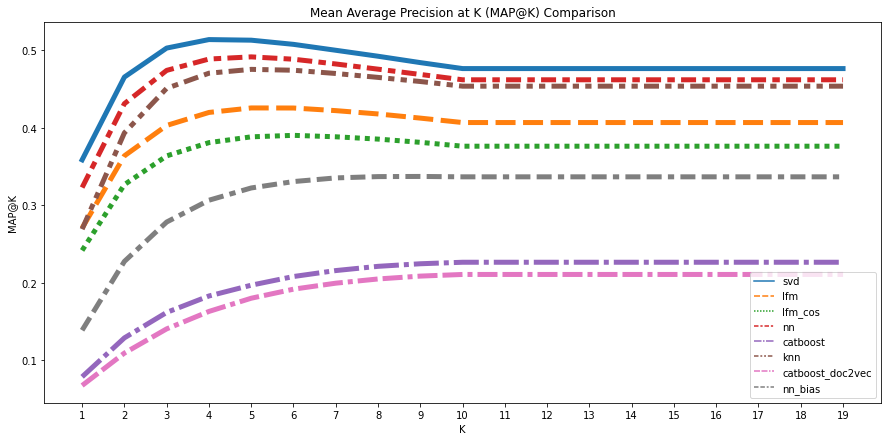

In [59]:


mapk_scores = [[] for _ in predictions]
names = list(predictions.keys())
for K in tqdm(np.arange(1, 20)):
    for i, (key, value) in enumerate(predictions.items()):
        mapk_scores[i].extend([mapk(actual, value, k=K)])
    

    
    
index = range(1,19+1)

fig = plt.figure(figsize=(15, 7))
mapk_plot(mapk_scores, model_names=names, k_range=index)

In [60]:


mapk_scores = [[] for _ in predictions]
names = list(predictions.keys())
for K in tqdm(np.arange(1, 20)):
    for i, (key, value) in enumerate(predictions.items()):
        mapk_scores[i].extend([mapk(actual, value, k=K)])
    

mapk_scores.append([])    

for K in tqdm(np.arange(1, 20)):
    mapk_scores[-1].extend([mapk(actual, result, k=K)])
names.append('result')        
        
index = range(1,19+1)

fig = plt.figure(figsize=(15, 7))
mapk_plot(mapk_scores, model_names=names, k_range=index)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

24983 0


AssertionError: Length mismatched

In [ ]:
mapk(actual, result, k=1)

In [ ]:
mapk(actual, result, k=10)

In [ ]:

mapk_scores = [[] for _ in predictions]
names = list(predictions.keys())
for i, (key, value) in enumerate(predictions.items()):
    mapk_scores[i].extend([mapk(actual, value, k=1)])
    
mapk_scores

In [ ]:
predictions.keys()

In [ ]:

mapk_scores = [[] for _ in predictions]
names = list(predictions.keys())
for i, (key, value) in enumerate(predictions.items()):
    mapk_scores[i].extend([mapk(actual, value, k=10)])
    
mapk_scores

In [ ]:
actual[0], predictions['nn'][0]

In [ ]:
for u in range(1000):
    x = _apk(actual[u], predictions['svd'][u], 1)
    if x > 0:
        print(u, x)
        break

In [ ]:
ndf = pd.DataFrame()

In [ ]:
ndf['UID'] = range(24983)
ndf

In [ ]:
ndf['JID'] = predictions['svd']
ndf

In [ ]:
ndf.explode('JID')

In [61]:
def get_value_popularity_ranks(values: pd.Series) -> pd.Series:
    value_counts = values.value_counts()
    counts_unique = value_counts.unique()
    count_rank_mapping = pd.Series(index=counts_unique, data=np.arange(len(counts_unique)) + 1)
    return value_counts.map(count_rank_mapping)


def calculate_serendipity_per_user(
    recommendations: pd.DataFrame,
    train: pd.DataFrame,
    test: pd.DataFrame,
) -> pd.Series:
    recommendations_ = pd.merge(recommendations, test[["UID", "JID"]], how="left", indicator=True)
    recommendations_["is_rel"] = np.where(recommendations_["_merge"] == "both", 1, 0)

    n_items = train["JID"].nunique()
    item_popularity_ranks = get_value_popularity_ranks(train["JID"])
    recommendations_["rank_pop"] = recommendations_["JID"].map(item_popularity_ranks)

    recommendations_["proba_user"] = (n_items + 1 - recommendations_["Ratings_pred"]) / n_items
    recommendations_["proba_any_user"] = (n_items + 1 - recommendations_["rank_pop"]) / n_items

    recommendations_["proba_diff"] = np.maximum(
        recommendations_["proba_user"] - recommendations_["proba_any_user"],
        0.0
    )
    recommendations_["item_serendipity"] = recommendations_["proba_diff"] * recommendations_["is_rel"]
    return recommendations_[["UID", "item_serendipity"]].groupby("UID").agg("mean")


In [ ]:
for key, value in frames.items():
    display(value)

In [62]:
for key, value in frames.items():
    c = value.columns
    if '_merge' in c:        
        #print(value.drop(columns = ['Rating','_merge']).columns)
        print(key, calculate_serendipity_per_user(value.drop(columns = ['Rating','_merge']).rename(columns = {'Rating_pred':'Ratings_pred'}), df_train, df_test).mean())
    elif 'rank' in c:    
        #print(value.rename(columns = {'rank':'Ratings_pred'}).columns)
        print(
            key, calculate_serendipity_per_user(
                value.rename(columns = {'rank':'Ratings_pred'}), df_train, df_test).mean())
        
    elif 'Rating_pred' in c:
        #print(c)
        print(key, calculate_serendipity_per_user(
                value.rename(columns = {'Rating_pred':'Ratings_pred'}), df_train, df_test).mean())
        #print(key, calculate_serendipity_per_user(value, df_train, df_test).mean())
    #break
    #

svd item_serendipity    0.12573
dtype: float64
lfm item_serendipity    0.168735
dtype: float64
lfm_cos item_serendipity    0.250702
dtype: float64
nn item_serendipity    0.091932
dtype: float64
catboost item_serendipity    0.102744
dtype: float64
knn item_serendipity    0.089807
dtype: float64
catboost_doc2vec item_serendipity    0.10844
dtype: float64
nn_bias item_serendipity    0.117806
dtype: float64


In [63]:
def novelty(predicted: List[list], pop: dict, u: int, n: int) -> (float, list):
    """
    Новизна рекомендаций 
    ----------    
    Базируется на статье:
    Zhou, T., Kuscsik, Z., Liu, J. G., Medo, M., Wakeling, J. R., & Zhang, Y. C. (2010).
    Solving the apparent diversity-accuracy dilemma of recommender systems.
    Proceedings of the National Academy of Sciences, 107(10), 4511-4515.
    """
    mean_self_information = []
    k = 0
    for sublist in predicted:
        self_information = 0
        k += 1
        for i in sublist:
            self_information += np.sum(-np.log2(pop[i]/u))
        mean_self_information.append(self_information/n)
    novelty = sum(mean_self_information)/k
    return novelty, mean_self_information


In [64]:
nov = df.JID.value_counts()
pop = dict(nov)
users = np.unique(df['UID'])

nov_dict = {}
for i, (key, value) in enumerate(predictions.items()):
    nov, _ = novelty(value, pop, len(users), 10)
    nov_dict[key] = nov
    
nov_dict

{'svd': 0.806467708440091,
 'lfm': 0.5569537579748091,
 'lfm_cos': 0.8783698040593366,
 'nn': 0.6580521718327331,
 'catboost': 0.707472849104188,
 'knn': 0.7036449777630319,
 'catboost_doc2vec': 0.7705851122539147,
 'nn_bias': 0.9501798609400355}

In [ ]:
users = np.unique(df['UID'])
users

In [ ]:
assert False

In [67]:
items = np.unique(df['JID'])
items

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [68]:
def prediction_coverage(predicted: List[list], catalog: list, unseen_warning: bool=False) -> float:
    """
    Покрытие рекомендаций (по пользователю)
    
    ----------    
    Базируется на статье:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    
    unique_items_catalog = set(catalog)
    if len(catalog)!=len(unique_items_catalog):
        raise AssertionError("Дубликаты в каталоге")

    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_items_pred = set(predicted_flattened)
    
    if not unique_items_pred.issubset(unique_items_catalog):
        if unseen_warning:
            warnings.warn("В рекомендациях есть элементы не из каталога. "
                "Игнорируем")
            unique_items_pred = unique_items_pred.intersection(unique_items_catalog)
        else:
            print(unique_items_pred - unique_items_catalog)
            raise AssertionError("В рекомендациях есть элементы не из каталога.")
    
    num_unique_predictions = len(unique_items_pred)
    prediction_coverage = round(num_unique_predictions/(len(catalog)* 1.0)* 100, 2)
    return prediction_coverage



In [69]:

cov_dict = {}
for i, (key, value) in enumerate(predictions.items()):
    cov = prediction_coverage(value, items)
    cov_dict[key] = cov

    
cov_dict

{'svd': 100.0,
 'lfm': 100.0,
 'lfm_cos': 100.0,
 'nn': 95.0,
 'catboost': 54.0,
 'knn': 89.0,
 'catboost_doc2vec': 75.0,
 'nn_bias': 99.0}

In [70]:

def catalog_coverage(predicted: List[list], catalog: list, k: int) -> float:
    """
    Покрытие рекомендаций (по каталогу)
    
    ----------
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage



def coverage_plot(coverage_scores: list, model_names: list) -> None:
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

In [71]:

catalog_cov_dict = {}
for i, (key, value) in enumerate(predictions.items()):
    cov = catalog_coverage(value, items, 100)
    catalog_cov_dict[key] = cov

    
catalog_cov_dict

{'svd': 89.0,
 'lfm': 99.0,
 'lfm_cos': 100.0,
 'nn': 46.0,
 'catboost': 34.0,
 'knn': 35.0,
 'catboost_doc2vec': 39.0,
 'nn_bias': 71.0}

In [ ]:
assert False

In [ ]:
# N=100 для определенного 
#random_cat_coverage = catalog_coverage(ran_recs, items, 100)
#pop_cat_coverage = catalog_coverage(pop_recs, items, 100)
cf_cat_coverage = catalog_coverage(svd_predictions, items, 100)
lfm_cat_coverage = catalog_coverage(lfm_predictions, items, 100)
lfm_cos_cat_coverage = catalog_coverage(lfm_cos_predictions, items, 100)

In [ ]:

cf_cat_coverage, lfm_cat_coverage, lfm_cos_cat_coverage

In [ ]:
frames2 = {'svd':svd_df, 'lfm_cos':lfm_cos_df, 'nn':nn_df, 
         'knn':knn_df, 'catboost_doc2vec':catboost_doc2vec_df}

predictions2 = {k:list(v.groupby('UID').agg({'JID':list})['JID'].values) for k, v in frames2.items()}

In [ ]:
len(predictions['svd'])

In [ ]:
intersect = [[] for _ in range(len(predictions2['svd']))]

for i, (key1, value1) in enumerate(tqdm(predictions2.items())):
    for j, (key2, value2) in enumerate(predictions2.items()):    
        if j <= i:
            continue
            
        for ii in range(24983):
            for v in value1[ii]:            
                if v in value2[ii]:
                    intersect[ii].append((key1, key2, v))
                
             
    intersect.append(inters)

In [ ]:
intersect[0]

In [ ]:
cc = Counter(intersect[9])
cc

In [ ]:
predictions['svd'][0]

In [ ]:
{x: 0.1 * (10-i) for i, x in enumerate(predictions['svd'][0])}

In [ ]:
{x: 0.1 * (10-i) for i, x in enumerate(predictions['knn'][0])}

In [ ]:
{x: 0.1 * (10-i) for i, x in enumerate(predictions['nn'][0])}

In [ ]:
predictions_df['actual']

In [ ]:
predictions_df['svd']

In [ ]:
users = np.unique(predictions_df['actual']['UID'])
users

In [ ]:
ndsg = {}

for user in tqdm(users):
    df1 = predictions_df['actual'][predictions_df['actual']['UID'] == user]
    df2 = predictions_df['svd'][predictions_df['svd']['UID'] == user]
    
    break
    
    if len(df_user) < 2:
        continue
    #display(df_user)
    #display(np.asarray([df_user['Ratings']]))
    ndsg[user] = ndcg_score(
        np.asarray([['Ratings']]),
        np.asarray([predictions_df['svd']['Ratings_pred']])
    )

    
np.mean(list(ndsg.values()))

In [ ]:
df1

In [ ]:
df2

In [ ]:
df_pred = df_pred.merge(pd.DataFrame({'UID':ndsg.keys(), 'NDSG': list(ndsg.values())}), how='left')#
df_pred

In [ ]:
df_pred[df_pred['NDSG'].isna()]

In [ ]:
df_pred = df_pred.fillna(0)

In [ ]:
df_pred[df_pred['NDSG'].isna()]

In [ ]:
df_pred['NDSG'].mean()

In [ ]:
pop = dict(df['UID'].value_counts())
pop

In [ ]:
cf_recs = []

for user in tqdm(users):
    df_user = df_pred[df_pred['UID'] == user]
    

In [ ]:
df_pred.index

In [ ]:
test = df_true.copy().groupby('UID', as_index=False)['JID'].agg({'Ratings': (lambda x: list(set(x)))}).sort_values('Ratings')
test = test.set_index("UID")
test

In [ ]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["Ratings_pred"]
    recommended_items = recommended_items.sort_values('Ratings_pred', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [ ]:
cf_model = df_pred.pivot_table(index='UID', columns='JID', values='Ratings_pred').fillna(0)
cf_model

In [ ]:

cf_recs = []
for user in tqdm(test.index):
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

In [ ]:
# рекомендации по популярным 
popularity_recs = df['JID'].value_counts().head(10).index.tolist()

pop_recs = []
for user in tqdm(test.index):
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

In [ ]:
items = np.unique(df['JID'])
items

In [ ]:
# рекомендации случайных
ran_recs = []
for user in tqdm(test.index):
    random_predictions = np.random.choice(items, 10)
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

In [ ]:
actual = test.Ratings.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [ ]:
lfm_dataset = LFMDataset()
lfm_dataset.fit(
    users=df_train["UID"].values,
    items=df_train["JID"].values,
)

train_matrix, _ = lfm_dataset.build_interactions(zip(*df_train[["UID", "JID"]].values.T))

In [ ]:
id_item_mapping = {v: k for k, v in lfm_dataset._item_id_mapping.items()}

In [33]:
lfm_model = LightFM(
    learning_rate=0.01, 
    loss='warp', 
    no_components=64,
    random_state=42
)
lfm_model.fit(
    interactions=train_matrix, 
    epochs=15,
    num_threads=20
);

NameError: name 'train_matrix' is not defined

In [ ]:
with open('05_jokes_lfm_model.pkl', 'wb') as f:
    pickle.dump(lfm_model, f)

In [ ]:
with open('05_jokes_lfm_dataset.pkl', 'wb') as f:
    pickle.dump(lfm_dataset, f)

In [ ]:
lfm_model_cos = deepcopy(lfm_model)

lfm_model_cos.item_biases = np.zeros_like(lfm_model_cos.item_biases)
lfm_model_cos.user_biases = np.zeros_like(lfm_model_cos.user_biases)

lfm_model_cos.item_embeddings = normalize(lfm_model_cos.item_embeddings)
lfm_model_cos.user_embeddings = normalize(lfm_model_cos.user_embeddings)

In [ ]:
{x:lfm_dataset._user_id_mapping[x] for x in list(lfm_dataset._user_id_mapping.keys())[-10:]}

In [ ]:
recommendations_dict = {}
for model_name, model in tqdm(models_dict.items()):
    recommendations = pd.DataFrame({"UID": df_test["UID"].unique()})
    recommendations["JID"] = recommendations["UID"].apply(
        lfm_get_n_recommendations_for_user,
        args=(
            model,
            train_matrix,
            lfm_dataset._user_id_mapping,
            id_item_mapping,
            n_predict,
            model_name
        ),
    )
    recommendations = recommendations.explode("JID")
    recommendations["rank"] = recommendations.groupby(["UID"]).cumcount() + 1
    recommendations_dict[model_name] = recommendations
    

In [ ]:
test

In [ ]:
actual = test.Ratings.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [ ]:
actual = df_test.groupby('UID', as_index=False)['JID'].agg({'JID': (lambda x: list(set(x)))}).sort_values('UID').JID.values.tolist()
actual

In [ ]:
lfm = recommendations_dict['lfm'].groupby('UID', as_index=False)['JID'].agg({'JID': (lambda x: list(set(x)))}).sort_values('UID').JID.values.tolist()
lfm

In [ ]:
lfm_cos = recommendations_dict['lfm_cos'].groupby('UID', as_index=False)['JID'].agg({'JID': (lambda x: list(set(x)))}).sort_values('UID').JID.values.tolist()
lfm_cos

In [ ]:

pop_mapk = []
for K in np.arange(1, 20):
    pop_mapk.extend([mapk(actual, pop_predictions, k=K)])


random_mapk = []
for K in np.arange(1, 20):
    random_mapk.extend([mapk(actual, random_predictions, k=K)])


cf_mapk = []
for K in np.arange(1, 20):
    cf_mapk.extend([mapk(actual, cf_predictions, k=K)])

In [ ]:

lfm_mapk = []
for K in np.arange(1, 20):
    lfm_mapk.extend([mapk(actual, lfm, k=K)])
    

lfm_cos_mapk = []
for K in np.arange(1, 20):
    lfm_cos_mapk.extend([mapk(actual, lfm_cos, k=K)])

In [ ]:

mapk_scores = [random_mapk, pop_mapk, cf_mapk, lfm_mapk, lfm_cos_mapk]
index = range(1,19+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter', 'LightFM', 'LightFM_cos']

fig = plt.figure(figsize=(15, 7))
mapk_plot(mapk_scores, model_names=names, k_range=index)

In [ ]:
cf_recs

In [ ]:

def catalog_coverage(predicted: List[list], catalog: list, k: int) -> float:
    """
    Покрытие рекомендаций (по каталогу)
    
    ----------
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage



def coverage_plot(coverage_scores: list, model_names: list) -> None:
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

In [ ]:
# N=100 для определенного 
random_cat_coverage = catalog_coverage(ran_recs, items, 100)
pop_cat_coverage = catalog_coverage(pop_recs, items, 100)
cf_cat_coverage = catalog_coverage(cf_recs, items, 100)
lfm_cat_coverage = catalog_coverage(lfm, items, 100)
lfm_cat_cos_coverage = catalog_coverage(lfm_cos, items, 100)

In [ ]:
# визуализация
coverage_scores = [random_coverage, pop_coverage, cf_coverage, lfm_cat_coverage, lfm_cat_cos_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter', 'lfm', 'lfm_cos']

fig = plt.figure(figsize=(7, 5))
coverage_plot(coverage_scores, model_names)

In [ ]:
nov = df.JID.value_counts()
pop = dict(nov)

In [ ]:
random_novelty,random_mselfinfo_list = novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = novelty(cf_recs, pop, len(users), 10)
lfm_novelty,lfm_mselfinfo_list = novelty(lfm, pop, len(users), 10)
lfm_cos_novelty,lfm_cos_mselfinfo_list = novelty(lfm_cos, pop, len(users), 10)

In [ ]:
print(random_novelty, pop_novelty, cf_novelty, lfm_novelty, lfm_cos_novelty)

In [ ]:
test_set_all

In [ ]:
predictions_all

In [ ]:
get_n_recommendations_for_user(df_pred_all, 4, 10)

In [ ]:
df_rec

In [ ]:
calculate_serendipity_per_user(df_rec, df_train, df_test).mean()

In [ ]:
calculate_serendipity_per_user(df_pred, df_train, df_test).mean()

In [ ]:


#random_coverage = prediction_coverage(ran_recs, items)
#pop_coverage = prediction_coverage(pop_recs, items)
cf_coverage = prediction_coverage(svd_predictions, items)
lfm_coverage = prediction_coverage(lfm_predictions, items)
lfm_cos_coverage = prediction_coverage(lfm_cos_predictions, items)


#random_coverage, pop_coverage, 
cf_coverage, lfm_coverage, lfm_cos_coverage

In [ ]:
nov = df.JID.value_counts()
pop = dict(nov)


svd_novelty, svd_mselfinfo_list = novelty(svd_predictions, pop, len(users), 10)
lfm_novelty, lfm_mselfinfo_list = novelty(lfm_predictions, pop, len(users), 10)
lfm_cos_novelty, lfm_cos_mselfinfo_list = novelty(lfm_cos_predictions, pop, len(users), 10)
svd_novelty, lfm_novelty, lfm_cos_novelty

In [34]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    interaction_type: str
        type of user-item interactions
        i.e. 'purchases', 'ratings' 'interactions', or 'clicks'
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_tables bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    Returns:
    -------
        A long tail plot
    """
    #calculate cumulative volumes
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x=x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()

    return volume_df

C:\Temp\ipykernel_840\1203623357.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


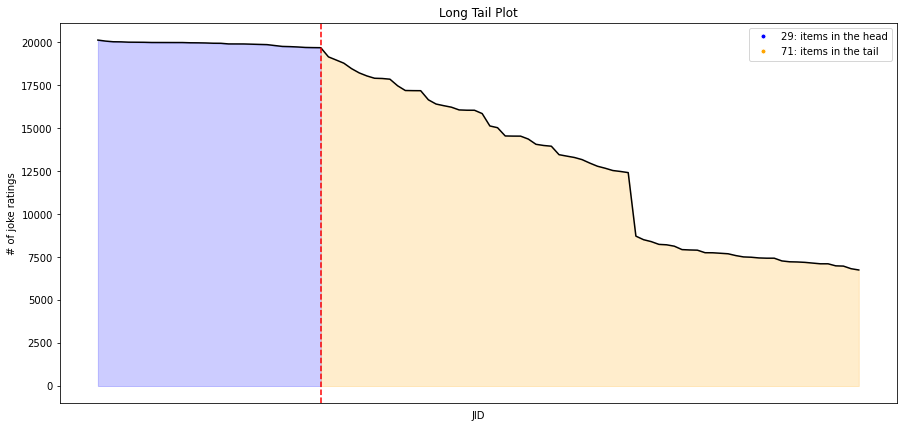

In [35]:
fig = plt.figure(figsize=(15, 7))
volume_df = long_tail_plot(df=df, 
             item_id_column="JID", 
             interaction_type="joke ratings", 
             percentage=0.4,
             x_labels=False)

In [36]:
volume_df.iloc[:30]

,JID,volume,cumulative_volume,percent_of_total_volume
0,6,20128,20128,0.013897
1,31,20069,40197,0.027753
2,15,20030,60227,0.041583
3,48,20025,80252,0.055409
4,17,20006,100258,0.069222
5,52,20003,120261,0.083032
6,20,19999,140260,0.096840
7,68,19988,160248,0.110641
8,14,19987,180235,0.124440
9,16,19986,200221,0.138239


In [37]:
volume_df.iloc[30:60]

,JID,volume,cumulative_volume,percent_of_total_volume
30,27,19151,616582,0.425709
31,25,18969,635551,0.438806
32,45,18784,654335,0.451775
33,38,18468,672803,0.464526
34,37,18219,691022,0.477105
35,13,18042,709064,0.489562
36,11,17907,726971,0.501926
37,39,17893,744864,0.514280
38,46,17852,762716,0.526605
39,10,17469,780185,0.538666


In [38]:
volume_df.iloc[60:90]

,JID,volume,cumulative_volume,percent_of_total_volume
60,36,13460,1104981,0.762917
61,32,13377,1118358,0.772153
62,2,13297,1131655,0.781333
63,0,13173,1144828,0.790428
64,43,12971,1157799,0.799384
65,56,12788,1170587,0.808213
66,23,12672,1183259,0.816962
67,8,12538,1195797,0.825619
68,3,12483,1208280,0.834238
69,57,12417,1220697,0.842811


In [39]:
volume_df.iloc[90:100]

,JID,volume,cumulative_volume,percent_of_total_volume
90,78,7228,1385034,0.956275
91,81,7217,1392251,0.961258
92,77,7194,1399445,0.966225
93,76,7152,1406597,0.971163
94,75,7111,1413708,0.976072
95,74,7111,1420819,0.980982
96,73,6992,1427811,0.985810
97,71,6977,1434788,0.990627
98,72,6825,1441613,0.995339
99,70,6751,1448364,1.000000


In [40]:
def weight_by_volume(x):
    if x < 0.1: return 0.1
    elif x > 0.1 and x < 0.2: return 0.2
    elif x > 0.2 and x < 0.3: return 0.3
    elif x > 0.3 and x < 0.4: return 0.4
    elif x > 0.4 and x < 0.5: return 0.5
    elif x > 0.5 and x < 0.6: return 0.5
    elif x > 0.6 and x < 0.7: return 0.4
    elif x > 0.7 and x < 0.8: return 0.3
    elif x > 0.8 and x < 0.9: return 0.2
    elif x > 0.9: return 0.1

In [41]:
volume_df['weight'] = volume_df['percent_of_total_volume'].apply(weight_by_volume)
volume_df

,JID,volume,cumulative_volume,percent_of_total_volume,weight
0,6,20128,20128,0.013897,0.1
1,31,20069,40197,0.027753,0.1
2,15,20030,60227,0.041583,0.1
3,48,20025,80252,0.055409,0.1
4,17,20006,100258,0.069222,0.1
...,...,...,...,...,...
95,74,7111,1420819,0.980982,0.1
96,73,6992,1427811,0.985810,0.1
97,71,6977,1434788,0.990627,0.1
98,72,6825,1441613,0.995339,0.1


In [42]:
joke_volume = {}
for row in volume_df.itertuples():
    joke_volume[int(row.JID)] = row.weight

In [43]:
joke_volume

{6: 0.1,
 31: 0.1,
 15: 0.1,
 48: 0.1,
 17: 0.1,
 52: 0.1,
 20: 0.1,
 68: 0.2,
 14: 0.2,
 16: 0.2,
 65: 0.2,
 61: 0.2,
 34: 0.2,
 19: 0.2,
 67: 0.3,
 12: 0.3,
 18: 0.3,
 26: 0.3,
 49: 0.3,
 60: 0.3,
 7: 0.3,
 4: 0.4,
 35: 0.4,
 28: 0.4,
 41: 0.4,
 64: 0.4,
 55: 0.4,
 30: 0.4,
 47: 0.4,
 53: 0.5,
 27: 0.5,
 25: 0.5,
 45: 0.5,
 38: 0.5,
 37: 0.5,
 13: 0.5,
 11: 0.5,
 39: 0.5,
 46: 0.5,
 10: 0.5,
 21: 0.5,
 44: 0.5,
 33: 0.5,
 24: 0.5,
 5: 0.5,
 9: 0.4,
 69: 0.4,
 62: 0.4,
 51: 0.4,
 22: 0.4,
 54: 0.4,
 50: 0.4,
 40: 0.4,
 1: 0.4,
 29: 0.3,
 58: 0.3,
 59: 0.3,
 42: 0.3,
 66: 0.3,
 63: 0.3,
 36: 0.3,
 32: 0.3,
 2: 0.3,
 0: 0.3,
 43: 0.3,
 56: 0.2,
 23: 0.2,
 8: 0.2,
 3: 0.2,
 57: 0.2,
 98: 0.2,
 97: 0.2,
 96: 0.2,
 95: 0.2,
 94: 0.2,
 93: 0.2,
 99: 0.2,
 92: 0.2,
 91: 0.2,
 90: 0.2,
 87: 0.1,
 89: 0.1,
 88: 0.1,
 86: 0.1,
 85: 0.1,
 84: 0.1,
 82: 0.1,
 83: 0.1,
 80: 0.1,
 79: 0.1,
 78: 0.1,
 81: 0.1,
 77: 0.1,
 76: 0.1,
 75: 0.1,
 74: 0.1,
 73: 0.1,
 71: 0.1,
 72: 0.1,
 70: 0.1}

In [44]:
df_top_joke = df[df['Rating'] > 5].groupby('JID').agg('count').rename(columns={'Rating':'count_plus'}) \
.sort_values('count_plus', ascending=False).drop(columns=['UID'])
df_top_joke

,count_plus
JID,
49,8828
26,8414
31,8121
35,8109
28,8098
...,...
74,1451
70,1446
15,1398


In [45]:
df_bottom_joke = df[df['Rating'] < -5].groupby('JID').agg('count').rename(columns={'Rating':'count_minus'}) \
.sort_values('count_minus', ascending=False).drop(columns=['UID'])
df_bottom_joke

,count_minus
JID,
15,8397
12,6269
14,6223
57,6135
6,5257
...,...
87,756
92,703
75,663


In [46]:
df_counts = df_bottom_joke.merge(df_top_joke, left_index=True, right_index=True)
df_counts

,count_minus,count_plus
JID,,
15,8397,1398
12,6269,2030
14,6223,2315
57,6135,883
6,5257,3793
...,...,...
87,756,2406
92,703,2668
75,663,2470


In [47]:
df_counts['diff'] = df_counts['count_plus'] - df_counts['count_minus']
df_counts = df_counts.sort_values('diff', ascending=False)
df_counts

,count_minus,count_plus,diff
JID,,,
49,1052,8828,7776
35,1125,8109,6984
26,1471,8414,6943
31,1294,8121,6827
61,1475,7825,6350
...,...,...,...
43,4579,1473,-3106
14,6223,2315,-3908
12,6269,2030,-4239


In [48]:
df_counts['weight'] = df_counts['diff'] / 10000
df_counts

,count_minus,count_plus,diff,weight
JID,,,,
49,1052,8828,7776,0.7776
35,1125,8109,6984,0.6984
26,1471,8414,6943,0.6943
31,1294,8121,6827,0.6827
61,1475,7825,6350,0.6350
...,...,...,...,...
43,4579,1473,-3106,-0.3106
14,6223,2315,-3908,-0.3908
12,6269,2030,-4239,-0.4239


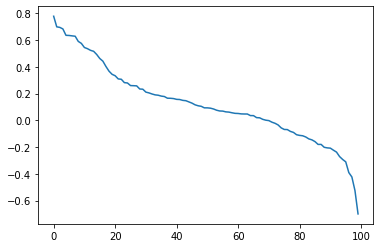

In [49]:
plt.plot(range(100), df_counts['weight'])

In [50]:
joke_quality = {}
for row in df_counts.itertuples():
    joke_quality[row.Index] = row.weight

In [51]:
joke_quality

{49: 0.7776,
 35: 0.6984,
 26: 0.6943,
 31: 0.6827,
 61: 0.635,
 34: 0.6339,
 28: 0.6309,
 52: 0.6282,
 53: 0.5896,
 48: 0.5748,
 67: 0.544,
 68: 0.5351,
 65: 0.5227,
 60: 0.5155,
 64: 0.4917,
 30: 0.4617,
 20: 0.442,
 41: 0.4023,
 47: 0.3671,
 55: 0.3436,
 10: 0.3328,
 88: 0.3091,
 27: 0.3065,
 45: 0.2814,
 46: 0.2788,
 13: 0.2594,
 5: 0.2585,
 11: 0.2572,
 25: 0.2338,
 37: 0.2322,
 9: 0.2105,
 71: 0.2046,
 92: 0.1965,
 38: 0.1899,
 39: 0.1873,
 75: 0.1807,
 44: 0.1776,
 87: 0.165,
 82: 0.1644,
 90: 0.1622,
 33: 0.1564,
 21: 0.1552,
 86: 0.1488,
 80: 0.1463,
 96: 0.1372,
 77: 0.128,
 95: 0.1155,
 99: 0.1084,
 0: 0.1044,
 91: 0.093,
 79: 0.0928,
 93: 0.0905,
 94: 0.0844,
 72: 0.0752,
 54: 0.0696,
 84: 0.0686,
 81: 0.0629,
 97: 0.0611,
 69: 0.0561,
 24: 0.0518,
 4: 0.0508,
 76: 0.0477,
 89: 0.0469,
 83: 0.0468,
 62: 0.035,
 2: 0.0348,
 1: 0.0198,
 85: 0.0184,
 22: 0.0071,
 78: 0.0007,
 18: -0.0025,
 98: -0.0143,
 74: -0.0225,
 51: -0.0348,
 70: -0.0567,
 59: -0.0686,
 40: -0.0695,
 29: 

In [52]:
def union_predicts():
    pass

In [53]:
result = []

for u in range(24983):
    res = {}
    for i, (key, value) in enumerate(predictions.items()):
        rank = {x: 0.1 * (10-j) for j, x in enumerate(value[u])}
        
        for k, v in rank.items():
            if k in res:
                res[k] += v
            else:
                res[k] = v
    for k in res:
        res[k] += joke_quality[k]
        res[k] += joke_volume[k]
    
    result.append([x[0] for x in sorted(res.items(), key=lambda item: item[1], reverse=True)][:10])

NameError: name 'predictions' is not defined

In [ ]:
result[0]

In [ ]:
result[200]

In [ ]:
recommendations = pd.DataFrame({"UID": df["UID"].unique()})
recommendations["JID"] = result
recommendations = recommendations.explode("JID")
recommendations["rank"] = recommendations.groupby(["UID"]).cumcount() + 1
recommendations

In [ ]:
calculate_serendipity_per_user(recommendations.rename(columns = {'rank':'Ratings_pred'}), df_train, df_test).mean()
        